# Define the model

$$
\begin{align*}
(\widehat{S}_{1k},...,\widehat{S}_{Ik})^T &\sim N((S_{1k}, . . . , S_{Ik})^T, \hat{\Sigma}_k )\\
    S_{ik} &\sim \delta_i P_0 + (1-\delta_i) (2M_i - 1) N(\beta_k x_i, \sigma_k^2)\\
    \beta_k &\sim N(\nu, \tau^2)\\
    M_i &\sim Bern(\phi_M)\\
    \delta_i &\sim Bern(\phi_\delta)\\
    \sigma_k^2 &\sim InvGamma(1, 0.001)\\
    \tau^2 &\sim InvGamma(1, 0.001)\\
    \nu &\sim N(0, 100)\\
\end{align*}
$$

Optionally, we can place hierarchical priors on $\phi_\delta, \phi_M$:

$$
\begin{align*}
    \phi_M &\sim Beta(u_M, v_M)\\
    \phi_\delta &\sim Beta(u_\delta, v_\delta)
\end{align*}
$$

I find that parametrizing $\beta_k$ with an unconstrained Normal improved mixing and convergence of the MCMC chains substantially. This results in multi-modal posterior distributions for $\{\beta_k\}_{k=1}^K$ and $\{M_i\}_{i=1}^I$. We can post-process to identify these parameters:

$$
\begin{align*}
    M_{ik} &= 0.5[(2M_i - 1)sign(\beta_k) + 1]\\
    \beta_k &= |\beta_k|
\end{align*}
$$

In [1]:
import numpy as np
import seaborn as sns
from scipy.stats import bernoulli, halfnorm, norm, gamma, invgamma, cauchy
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
import pymc as pm
print(f"Running on PyMC v{pm.__version__}")
import aesara.tensor as at
import pytensor.tensor as pt
from scipy.linalg import block_diag, cholesky
import arviz as az

Running on PyMC v5.1.2


In [3]:
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

In [4]:
# Remove constraints that beta is non-negative so the sampler explores the space
# more efficiently and removes divergences in Hamiltonian MC
# Post-process: 
#      m_ik = ((2m_i-1)*sign(beta_k) + 1) / 2
#      beta_k = abs(beta_k)

# ate: I \times K matrix of ATE estimates
# se: I \times K matrix of s.e. of the ATE estimates
# phi_d, phi_m: Empirical Bayes estimates of phi_d, phi_m; if None places hierarchical priors on them
# TODO: update code to take se as covariance matrix inputs
def get_model_unconstrained(ate, se, x=None, phi_d=None, phi_m=None, 
                            nu=None, tau=None, 
                            alpha_d=1, beta_d=1, alpha_m=1, beta_m=1,
                            alpha_sigma=0.001, beta_sigma=0.001
                           ):
    # Set the number of NCOs
    I = ate.shape[0]
    
    # Set the number of scenarios/treatment contrasts
    K = ate.shape[1]

    # Declare the dimensions of the data and parameters. 
    # This helps with organizing the indices of the posterior samples
    coords_nco = ['nco_'+str(i) for i in range(I)]
    coords_setting = ['setting_'+str(i) for i in range(K)]
    coords = {'nco': coords_nco, 'setting': coords_setting}
    
    # Initialize a model
    model = pm.Model(coords=coords)
    with model:
        
        # State input data as shared variables. Not sure if this is neccesary, but seems to be recommended in the documentation
        Y_t = pm.MutableData('Y', ate, dims=('nco', 'setting'))
        Sigma_t = pm.MutableData('Sigma', se, dims=('nco', 'setting')) # TODO: update to include covariances
        x_t = pt.ones(I) #pm.MutableData('x', x, dims='nco') # currently fix to a vector of ones for group-mean estimation

        # Priors for unknown model parameters
        if nu is None:
            nu_t = pm.Normal('nu', mu=0, sigma=100)
        else:
            nu_t = nu
        if tau is None:
            tau_t = pm.InverseGamma('tau', 0.001, 0.001)
        else:
            tau_t = tau
        if phi_d is None: 
            phi_d_t = pm.Beta('phi_d', alpha=alpha_d, beta=beta_d)
        else:
            phi_d_t = phi_d
        if phi_m is None: 
            phi_m_t = pm.Beta('phi_m', alpha=alpha_m, beta=beta_m)
        else:
            phi_m_t = phi_m
        beta_t = pm.Normal('beta', mu=nu_t, sigma=pt.sqrt(tau_t), size=K, dims='setting')
        sigma_t = pm.InverseGamma('sigma', alpha=alpha_sigma, beta=beta_sigma, size=K, dims='setting')
        delta_t = pm.Bernoulli('delta', p=phi_d_t, size=I, dims='nco')
        m_t = pm.Bernoulli('m', p=phi_m_t, size=I, dims='nco')
        # This seems to work better than the matrix normal prior
        slap_t = pm.Normal('slap', mu=pt.outer((2*m_t-1), beta_t), sigma=pt.outer(pt.ones(I), pt.sqrt(sigma_t)), dims=('nco', 'setting'))
        mu_t = pm.Deterministic('mu', pt.outer((1-delta_t), pt.ones(K))*slap_t, dims=('nco', 'setting'))

        # Likelihood model
        # TODO: make this a truncated likelihood -2 to 2?
        Y_obs = pm.Normal('Y_obs', mu=mu_t, sigma=Sigma_t, observed=Y_t, dims=('nco', 'setting'))

        # # Compound sampling step using MH + MWG + NUTS
        # if (mh_step):
        #     step = pm.CompoundStep([
        #                             pm.BinaryGibbsMetropolis([delta_t, m_t], transit_p=.42),
        #                             pm.Metropolis([beta_t, slap_t, sigma_t, tau_t])
        #                             ])
        #     return (model, step)
    
    return model

# Simulation

Simulate data from the following model but include 11 NCOs but no outcome with causal associations with treatment A:

<div>
<img src="dag-1.png" width="500"/>
</div>

Since there is no observed confounder, we can estimate the average causal effects and biases using difference in means or ratios of means. One NCO is excluded from fitting the model to use for checking the posterior predictive.

## Simulate data

In [5]:
# Set random seed
np.random.seed(42)
# Set number of observations
n = 1000
# Set number of unobserved confounders
p_u = 1
# Set number of treatment groups
n_a = 3
# Set number of scenarios/treatment contrasts
K = math.comb(n_a, 2)

# Generate latent space regression coefficients of U on A
alpha_u = np.random.uniform(0.25, 0.5, p_u)  # effect of U on treatment assigment A

# Generate unobserved confounder from standard normal
U = np.random.normal(size=(n, p_u))
# Generate another dataset with 1M samples to approximate the truth
U_1m = np.random.normal(size=(1000000, p_u))

# Define the treatment groups by discretizing the latent A according to quantiles
A = np.matmul(U, alpha_u)
# Add observation noise
A = A + np.random.normal(0, 1, size=n)
A_1m = np.matmul(U_1m, alpha_u) + np.random.normal(0, 1, size=len(U_1m))
# Generate the categorical treatment A using a probit model
A_obs = np.digitize(A, np.quantile(A_1m, np.linspace(0, 1, n_a+1))[0:n_a], right=False)
A_obs_1m = np.digitize(A_1m, np.quantile(A_1m, np.linspace(0, 1, n_a+1))[0:n_a], right=False)
# Reindex to start at 0
A_obs -= min(A_obs_1m)
A_obs_1m -= min(A_obs_1m)

# Create one-hot-encoding of A_obs: n \times n_a
unique_values = np.unique(A_obs_1m)
identity_matrix = np.eye(len(unique_values))
A_encoded = identity_matrix[np.searchsorted(unique_values, A_obs)]

In [6]:
# Define number of NCOs
I = 10

# Define the effects of U on the NCOs in latent space
beta_u_low = 0.5
beta_u_high = 1
theta_u = np.random.uniform(beta_u_low, beta_u_high, size=(p_u, I+1))

# Randomly zero-out the effects
theta_u *= np.random.choice([0, 1], size=(p_u, I+1))

# Randomly shuffle the sign of the effects with probability 0.5
theta_u *= np.random.choice([-1, 1], size=(p_u, I+1))

# Generate the latent NCOs
noise_se = 0.5
N_1m = np.matmul(U_1m, theta_u) + np.random.normal(0, noise_se, size=(len(U_1m), I+1)) # use large sample of 1M observations to approx true bias
N = np.matmul(U, theta_u) + np.random.normal(0, noise_se, size=(n, I+1))

# Discretize the latent NCOs
N_obs_1m = 1*(N_1m > np.zeros(I+1))
N_obs = 1*(N > np.zeros(I+1))

# Calculate the difference in means or biases
bias_N_true = [] # based on 1M samples
bias_N = []
for i in range(n_a-1):
    for j in range(i+1, n_a):
        bias_N.append(np.mean(N_obs[A_obs == j,:], axis=0) - np.mean(N_obs[A_obs == i,:], axis=0))
        bias_N_true.append(np.mean(N_obs_1m[A_obs_1m == j,:], axis=0) - np.mean(N_obs_1m[A_obs_1m == i,:], axis=0))
bias_N = np.array(bias_N).transpose()
bias_N_true = np.array(bias_N_true).transpose()
bias_N

array([[-0.01351068, -0.00467125,  0.00883943],
       [ 0.17008798,  0.26599327,  0.09590529],
       [ 0.20737327,  0.28945129,  0.08207802],
       [ 0.1787809 ,  0.28381803,  0.10503714],
       [-0.16652702, -0.24240574, -0.07587872],
       [-0.08598659, -0.0480723 ,  0.0379143 ]])

In [7]:
# Define function for statistics: s.e. for the biases
def get_boostrap_bias(indices, ncos, treatment, n):
    b_ncos = ncos[indices, :]
    b_treatment = treatment[indices]
    b_bias = []
    for i in range(n-1):
        for j in range(i+1, n):
            b_bias.append(np.mean(b_ncos[b_treatment==j,:], axis=0) - np.mean(b_ncos[b_treatment==i,:], axis=0))
    return np.array(b_bias).transpose()

# Set the number of bootstrap samples
n_bootstrap = 100
# Create random sample with replacement of row indinces
b_indices = np.random.choice(range(n), size=(n_bootstrap, n), replace=True)
# Apply statistics to bootstrapped samples
b_bias = np.apply_along_axis(get_boostrap_bias, axis=1, arr=b_indices, ncos=N_obs, treatment=A_obs, n=n_a)
# Calculate s.e. of statistics in bootstrap samples
se_bias_N = np.std(b_bias, axis=0, ddof=1)
se_bias_N

array([[0.03691265, 0.03844269, 0.03515709],
       [0.04737697, 0.04150754, 0.04283983],
       [0.03975421, 0.03848466, 0.04355355],
       [0.039901  , 0.03832405, 0.04184407],
       [0.03752101, 0.03783076, 0.03583155],
       [0.03912142, 0.03663629, 0.03481557]])

In [8]:
# Convert matrix of biases to dataframe
data_columns = ['setting_' + str(i) for i in range(K)]
data_index = ['nco_' + str(i) for i in range(I)]
data = pd.DataFrame(bias_N[:I,], columns=data_columns)
data['nco'] = data_index
data_long = pd.melt(data,
                    id_vars=['nco'],
                    value_vars=data_columns, 
                    var_name='setting', value_name='bias')
data_long['se'] = se_bias_N[:I,].flatten('F')
data_long['true_bias'] = bias_N_true[:I,].flatten('F')
print(data_long.head(3))

     nco    setting      bias        se  true_bias
0  nco_0  setting_0 -0.013511  0.036913   0.000459
1  nco_1  setting_0  0.170088  0.047377   0.122127
2  nco_2  setting_0  0.207373  0.039754   0.121128


In [9]:
# Define the correct delta: all zero because U has an effect on each NCO
true_delta = 1*(theta_u[0, :I] == 0)
# True scenario mean bias
true_beta = np.abs(bias_N_true[:I,][true_delta==0,]).mean(axis=0)
# Define the correct M: sign of the effect of U on NCOs
true_M = (np.sign(theta_u[:,:I]) + 1) // 2
true_M = true_M.reshape((I,))
print(true_delta.mean())
print(true_M.mean())
print(true_beta)

0.2
0.6
[0.12214737 0.24369063 0.12154326]


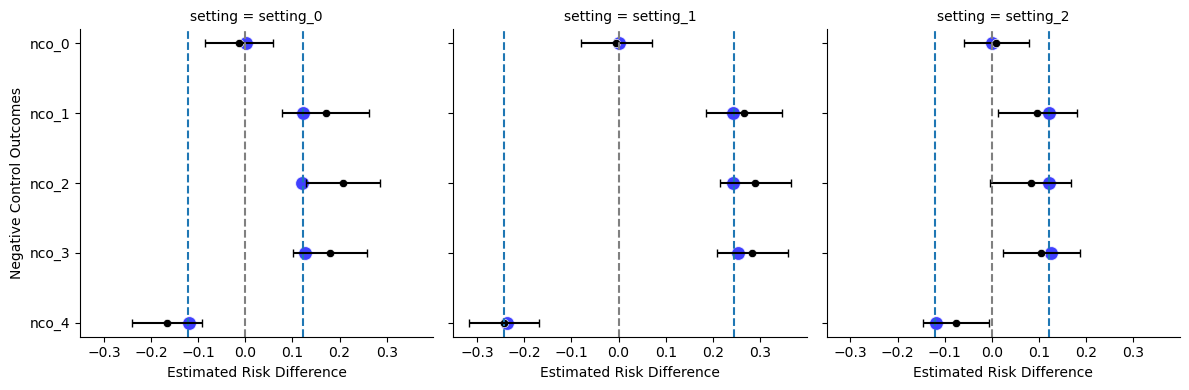

In [10]:
# Initialize a facet grid plot
g = sns.FacetGrid(data_long, col='setting', height=4, aspect=1)

# Add verticle blue line at true mean bias
axes = g.axes[0]
for ax, muk in zip(axes, true_beta):
    ax.axvline(muk, ls='--')
    ax.axvline(-muk, ls='--')

# Create the scatter plot of true bias in blue
g.map(sns.scatterplot, 'true_bias', 'nco', alpha=0.75, color='blue', s=100)

# Create the scatter plot of the simulated data
g.map(sns.scatterplot, 'bias', 'nco', alpha=1, color='black')

# Function to add error bars
def add_error_bars(x, y, error, **kwargs):
    data = kwargs.pop("data")
    ax = plt.gca()
    for i, (_, row) in enumerate(data.iterrows()):
        ax.errorbar(row['bias'], row['nco'], xerr=1.96*row['se'], fmt='none', ecolor='black', capsize=3)

# Add error bars faceted by 'type'
g.map_dataframe(add_error_bars, 'bias', 'nco', 'se')

# Add verticle line at 0.0
g.refline(x=0.0)

# Change x axis label
g.set_axis_labels("Estimated Risk Difference", "Negative Control Outcomes")

# Show the plot
plt.show()

## Fit the model using different choices of hyperparams for the prior

In [11]:
# Set parameters for fitting models
n_samples = 2000
n_tune = 20000
n_chains = 4

#### Specifying proportions (close to correct)

In [12]:
# Intialize model with phi_d and phi_m closed to the true values
model_cor = get_model_unconstrained(bias_N[:I,:], se_bias_N[:I,:], 
                                    phi_d=true_delta.mean()+0.03, 
                                    phi_m=true_M.mean()-0.03,
                                    alpha_sigma=1
                                   )
with model_cor:
    # MCMC sampling
    trace_cor = pm.sample(n_samples, tune=n_tune, chains=n_chains, 
                          target_accept=0.9, random_seed=RANDOM_SEED)

/Users/phucnguyen/miniconda3/envs/pymc_env/lib/python3.11/site-packages/multipledispatch/dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [nu, tau, beta, sigma, slap]
>BinaryGibbsMetr

Sampling 4 chains for 20_000 tune and 2_000 draw iterations (80_000 + 8_000 draws total) took 45 seconds.
/Users/phucnguyen/miniconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


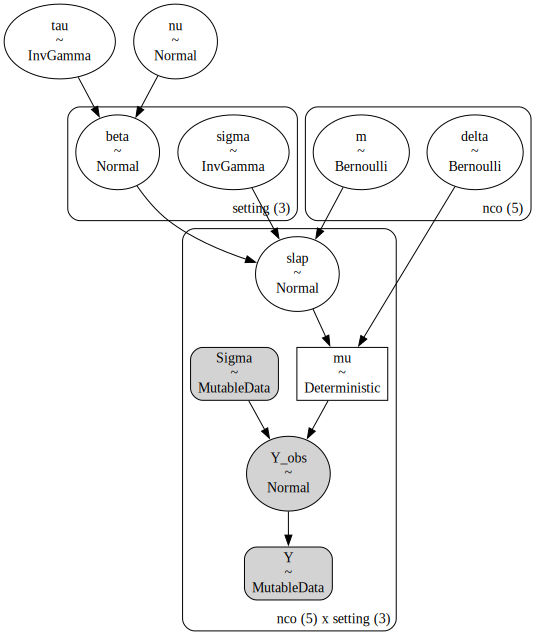

In [13]:
pm.model_to_graphviz(model_cor)

In [14]:
# Convergence diagnostics, requires multiple chains
az.summary(trace_cor, var_names=['beta', 'tau', 'sigma']).round(3)
# No convergence for beta because the posterior is bimodal (invariance in sign)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[setting_0],0.091,0.159,-0.207,0.230,0.078,0.060,7.0,27.0,1.53
beta[setting_1],0.132,0.230,-0.294,0.310,0.114,0.087,7.0,30.0,1.53
beta[setting_2],0.048,0.089,-0.131,0.144,0.042,0.032,7.0,28.0,1.53
tau,2.652,67.864,0.000,0.200,2.206,1.561,534.0,171.0,1.01
sigma[setting_0],0.001,0.002,0.000,0.003,0.000,0.000,3447.0,3259.0,1.00
sigma[setting_1],0.001,0.002,0.000,0.003,0.000,0.000,3402.0,2966.0,1.00
sigma[setting_2],0.001,0.002,0.000,0.004,0.000,0.000,3597.0,3635.0,1.00


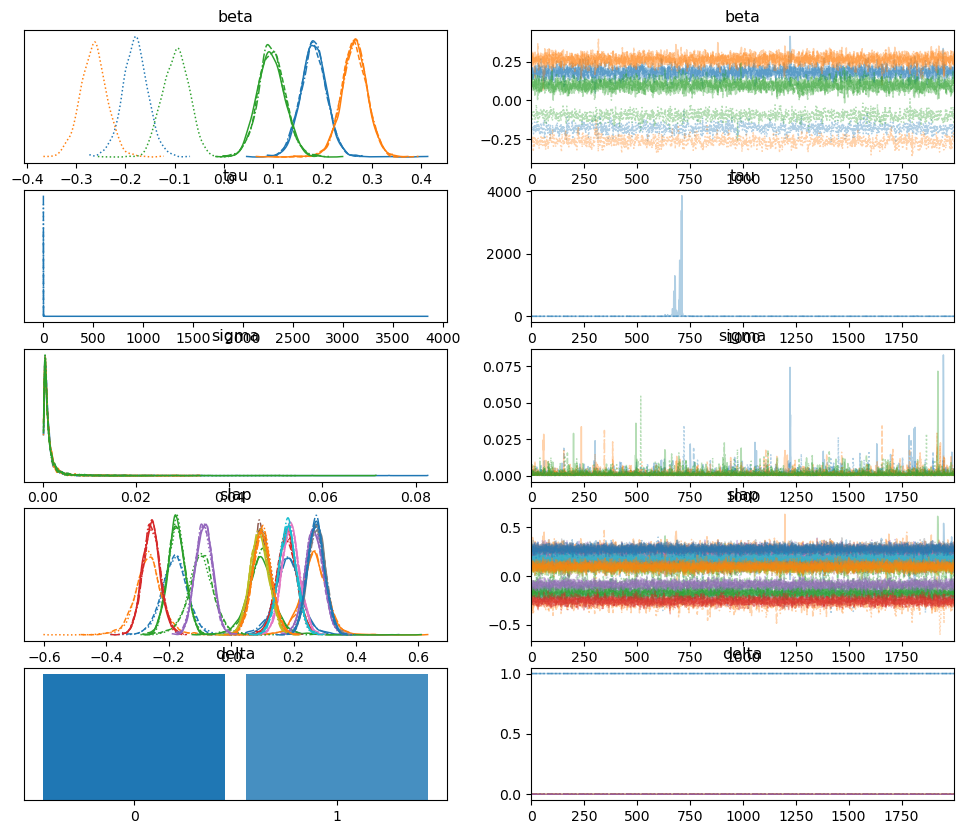

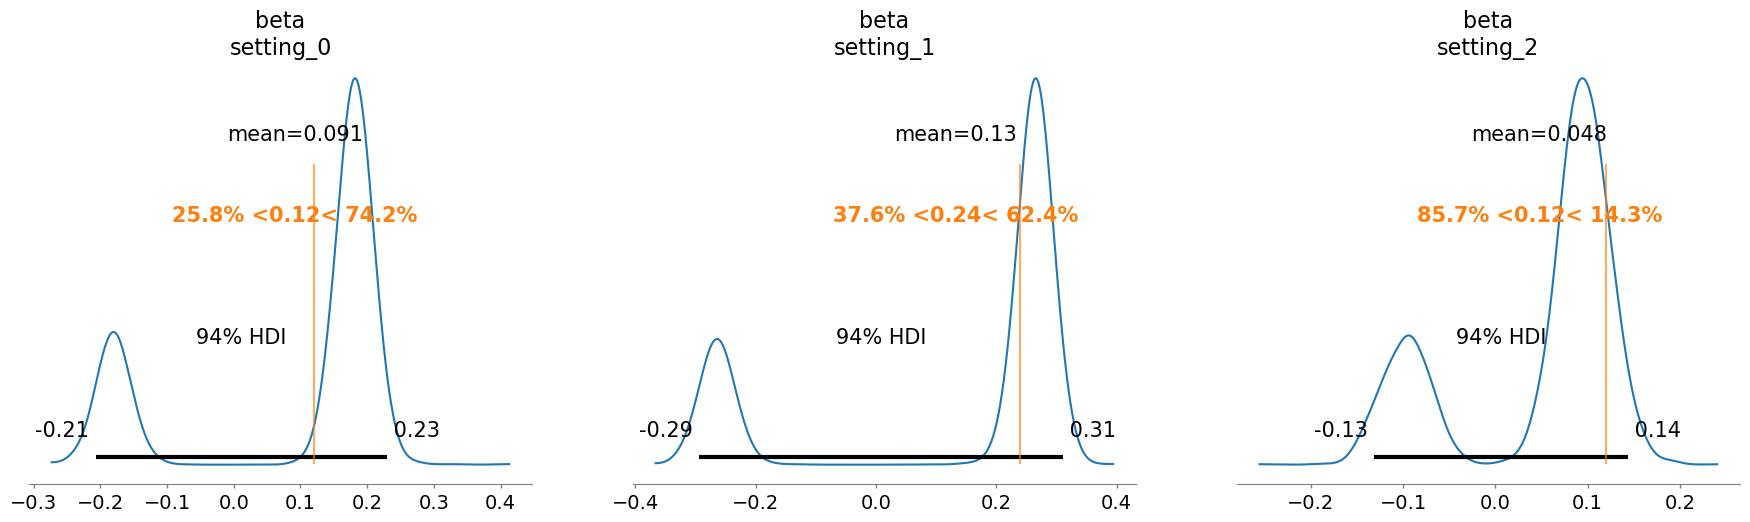

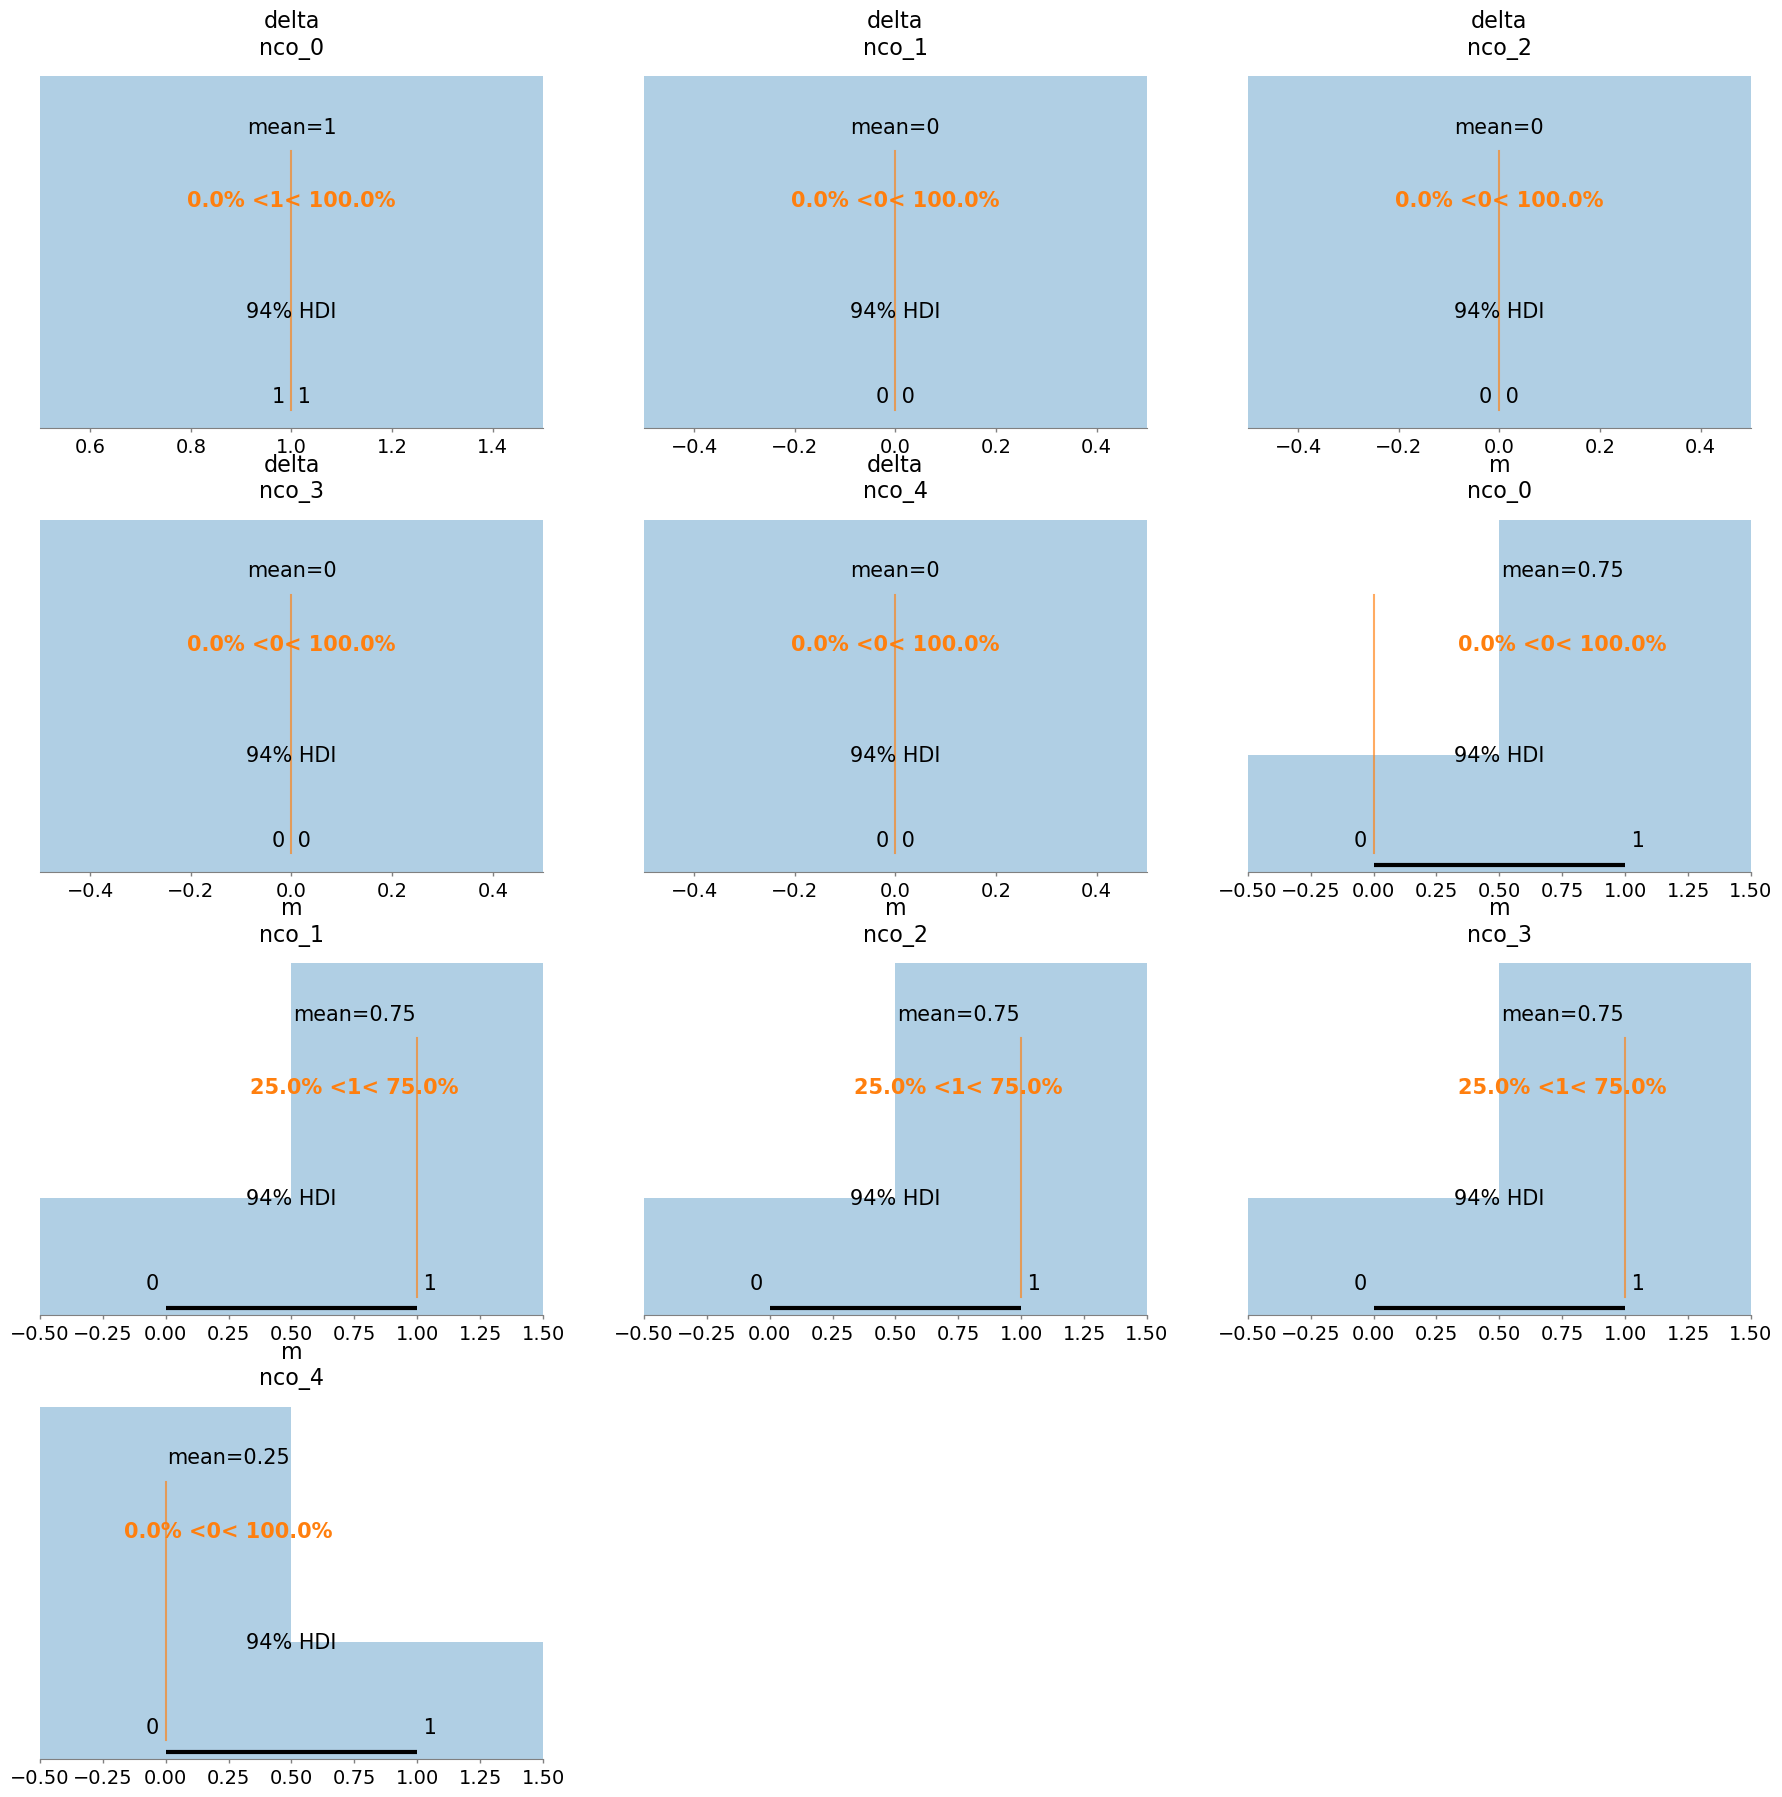

In [15]:
# Diagnose convergence by plotting posterior density and trace plots
az.plot_trace(trace_cor, var_names=["beta", "tau", "sigma", "slap", "delta"]); # expected magnitude of the bias in each treatment contrast

# Plot individual posterior density and true values written in orange
az.plot_posterior(trace_cor, var_names="beta", ref_val=true_beta.round(2).tolist());
az.plot_posterior(trace_cor, var_names=["delta", 'm'], 
                  ref_val=np.concatenate((true_delta, true_M)).astype(int).tolist());

#### Uninformative hierarchical priors

<!-- $$u_M = 10\phi_M, u_\delta = 10\phi_\delta$$
$$v_M = 10-u_M, v_\delta = 10-u_\delta$$ -->

$$u_M = 1, u_\delta = 1$$
$$v_M = 1, v_\delta = 1$$

In [16]:
# model_hp = get_model_unconstrained(bias_N[:I,:], se_bias_N[:I,:], 
#                                    alpha_d=10*true_delta.mean(), beta_d=10*(1-true_delta.mean()), 
#                                    alpha_m=10*true_M.mean(), beta_m=10*(1-true_M.mean()))
model_hp = get_model_unconstrained(bias_N[:I,:], se_bias_N[:I,:], 
                                   alpha_d=1, beta_d=1, alpha_m=1, beta_m=1,
                                   alpha_sigma=1
                                  )
with model_hp:
    # MCMC sampling
    trace_hp = pm.sample(n_samples, tune=n_tune, chains=n_chains, 
                         target_accept=0.9, random_seed=RANDOM_SEED)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [nu, tau, phi_d, phi_m, beta, sigma, slap]
>BinaryGibbsMetropolis: [delta, m]


Sampling 4 chains for 20_000 tune and 2_000 draw iterations (80_000 + 8_000 draws total) took 67 seconds.
/Users/phucnguyen/miniconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [17]:
# Convergence diagnostics, requires multiple chains
az.summary(trace_hp, var_names=['beta', 'tau', 'sigma', 'nu', 'phi_d', 'phi_m']).round(3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[setting_0],0.094,0.162,-0.212,0.242,0.080,0.061,7.0,29.0,1.53
beta[setting_1],0.133,0.232,-0.296,0.320,0.115,0.088,7.0,32.0,1.53
beta[setting_2],0.053,0.094,-0.132,0.164,0.044,0.033,7.0,29.0,1.53
tau,0.063,0.526,0.000,0.144,0.010,0.007,2205.0,1711.0,1.00
sigma[setting_0],0.002,0.003,0.000,0.004,0.000,0.000,2398.0,2295.0,1.00
sigma[setting_1],0.002,0.003,0.000,0.005,0.000,0.000,2441.0,2824.0,1.00
sigma[setting_2],0.002,0.004,0.000,0.005,0.000,0.000,2472.0,2755.0,1.00
nu,0.087,0.208,-0.300,0.354,0.080,0.059,8.0,62.0,1.41
phi_d,0.391,0.180,0.059,0.704,0.031,0.022,32.0,139.0,1.08
phi_m,0.642,0.280,0.149,1.000,0.122,0.091,6.0,31.0,1.74


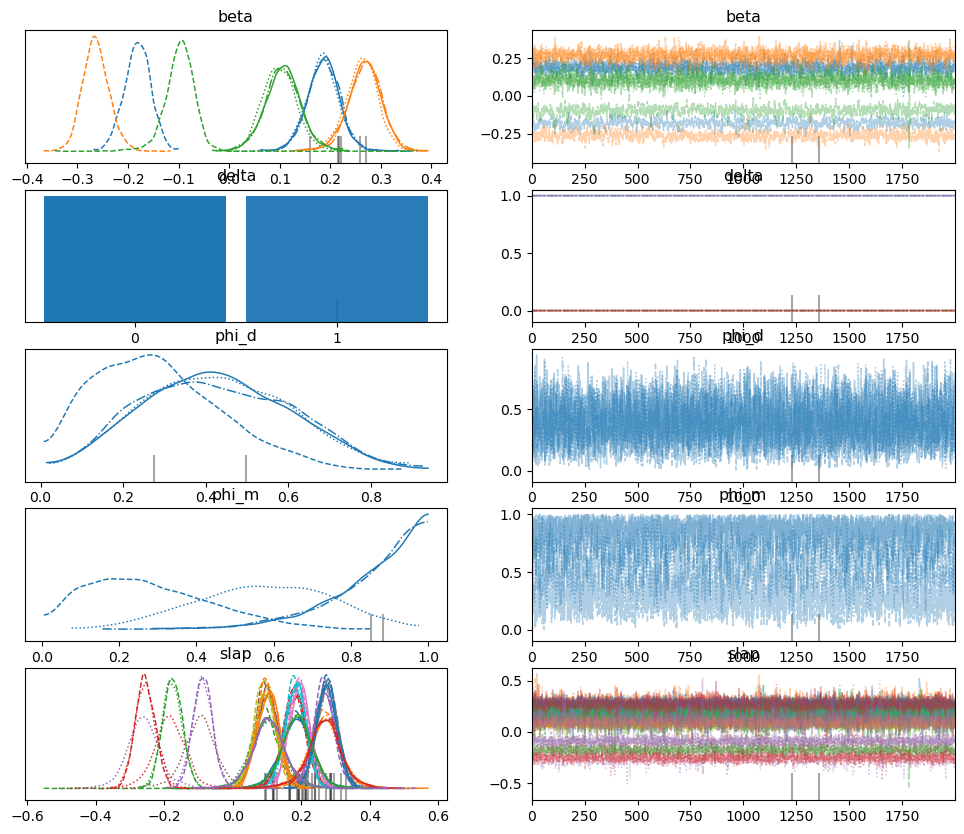

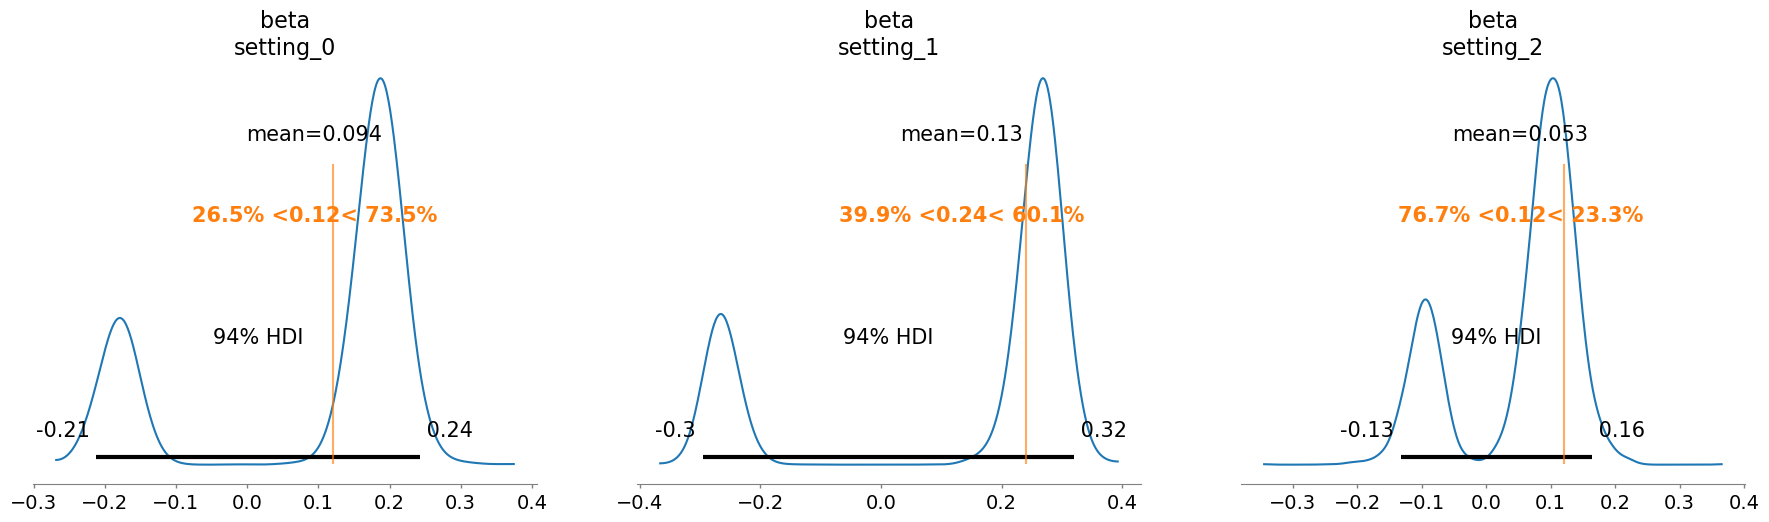

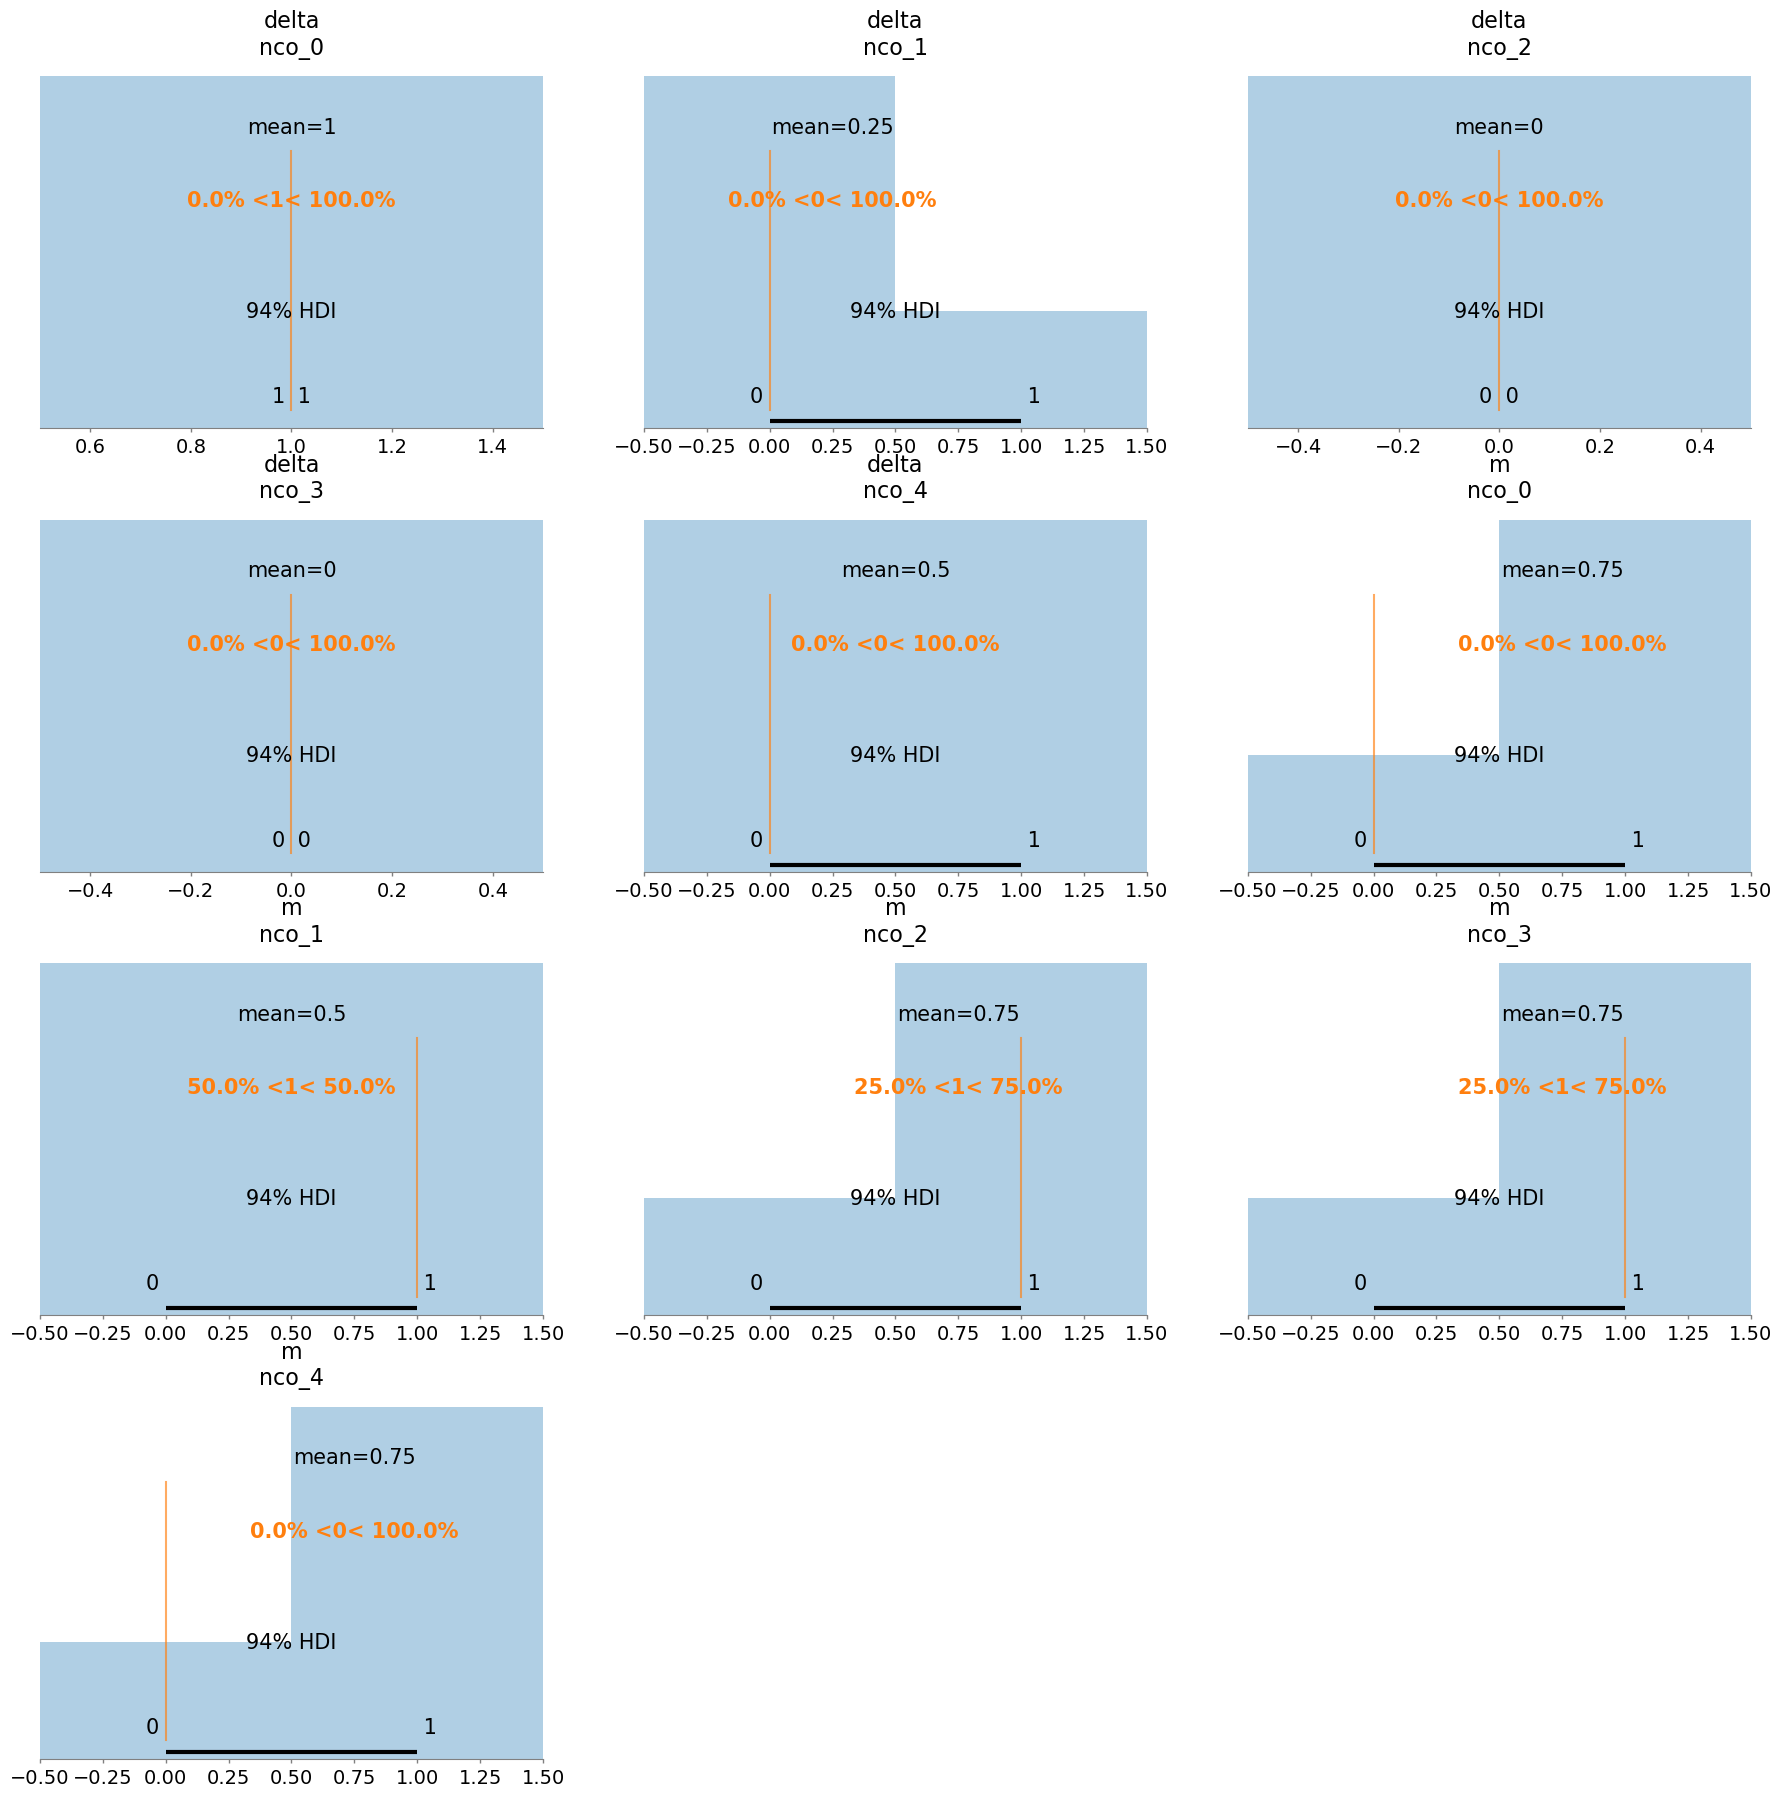

In [18]:
# Diagnose convergence by plotting posterior density and trace plots
az.plot_trace(trace_hp, var_names=["beta", 'delta', 'phi_d', 'phi_m', 'slap']); # expected magnitude of the bias in each treatment contrast

# Plot individual posterior density and true values written in orange
az.plot_posterior(trace_hp, var_names="beta", ref_val=true_beta.round(2).tolist());
az.plot_posterior(trace_hp, var_names=["delta", "m"], ref_val=np.concatenate((true_delta, true_M)).astype(int).tolist());

## Posterior predictive

In [19]:
# Predict the bias in Y, assuming we expect both A and U have protective effect on Y => M=1
# For each MCMC iteration: simulate \delta_Y| \phi_d => S_Yk|\delta_Y, \beta_k, \sigma_k for all K => ATE = ATE_obs - S_Yk
num_samps = 1000
samps_hp = az.extract(trace_hp, var_names=["phi_d", 'beta', 'sigma'], num_samples=num_samps).to_dataframe()
samps_hp = samps_hp.drop(['draw', 'chain'], axis=1)
samps_hp = samps_hp.reset_index()
samps_hp.sort_values(by=['chain', 'draw', 'setting'], inplace=True)
samps_hp['delta_y'] = np.repeat(np.random.binomial(1, samps_hp.groupby(['draw', 'chain'])['phi_d'].min()), K)
samps_hp['slap_y'] = np.random.normal(np.abs(samps_hp['beta']), samps_hp['sigma'], len(samps_hp))
samps_hp['bias_posterior'] = (1-samps_hp['delta_y'])*samps_hp['slap_y']
samps_hp['bias_y_obs'] = np.tile(bias_N_true[I,:], num_samps)
print(samps_hp.head(3))


      chain  draw    setting     phi_d      beta     sigma  delta_y    slap_y  \
2547      0     6  setting_0  0.318852  0.165769  0.000544        0  0.165203   
2548      0     6  setting_1  0.318852  0.277610  0.000398        0  0.277662   
2549      0     6  setting_2  0.318852  0.106380  0.000617        0  0.106833   

      bias_posterior  bias_y_obs  
2547        0.165203    0.000006  
2548        0.277662    0.000625  
2549        0.106833    0.000619  


In [20]:
# Predict the bias in Y, assuming we expect both A and U have protective effect on Y => M=1
# For each MCMC iteration: simulate \delta_Y| \phi_d => S_Yk|\delta_Y, \beta_k, \sigma_k for all K => ATE = ATE_obs - S_Yk
samps_cor = az.extract(trace_cor, var_names=['beta', 'sigma'], num_samples=num_samps).to_dataframe()
samps_cor = samps_cor.drop(['draw', 'chain'], axis=1)
samps_cor = samps_cor.reset_index()
samps_cor.sort_values(by=['chain', 'draw', 'setting'], inplace=True)
samps_cor['phi_d'] = true_delta.mean()+0.03
samps_cor['delta_y'] = np.repeat(np.random.binomial(1, samps_cor.groupby(['draw', 'chain'])['phi_d'].min()), K)
samps_cor['slap_y'] = np.random.normal(np.abs(samps_cor['beta']), samps_cor['sigma'], len(samps_cor))
samps_cor['bias_posterior'] = (1-samps_cor['delta_y'])*samps_cor['slap_y']
samps_cor['bias_y_obs'] = np.tile(bias_N_true[I,:], num_samps)
print(samps_cor.head(3))


        setting  chain  draw      beta     sigma  phi_d  delta_y    slap_y  \
546   setting_0      0    13  0.211284  0.000641   0.23        1  0.212449   
1546  setting_1      0    13  0.287257  0.000506   0.23        1  0.286895   
2546  setting_2      0    13  0.078497  0.000721   0.23        1  0.077608   

      bias_posterior  bias_y_obs  
546              0.0    0.000006  
1546             0.0    0.000625  
2546             0.0    0.000619  


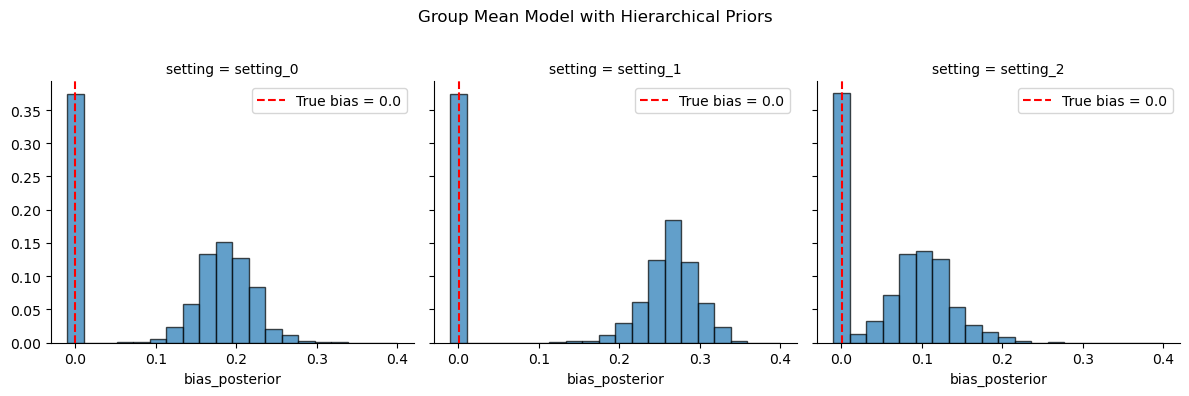

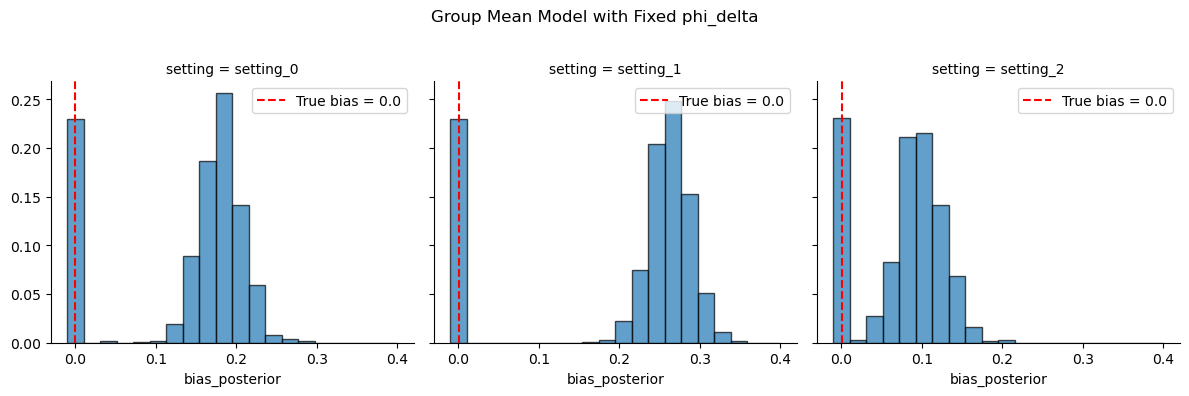

In [21]:
# Make truth a dictionary
# truth = dict(zip(data_columns, ate_Y))
# obs = dict(zip(data_columns, ate_Y_obs))
truth = dict(zip(data_columns, np.abs(bias_N_true[I,:])))

# Define weights so that the histogram bar at zero reflects the probability that the bias is zero
weights = np.ones(num_samps)/float(num_samps)

# Create a FacetGrid with histograms
data_list = [samps_hp, samps_cor]
plot_names = [
              'Group Mean Model with Hierarchical Priors',
              'Group Mean Model with Fixed phi_delta'
             ]
for dat, title in zip(data_list, plot_names):
    g = sns.FacetGrid(dat, col='setting', height=4, aspect=1)
    g.map(plt.hist, 'bias_posterior', edgecolor='k', bins=20, alpha=0.7, 
          weights=weights, range=(-0.01, 0.4))

    # Add vertical lines at truth values
    for ax, setting in zip(g.axes.flat, g.col_names):
        ax.axvline(truth[setting], color='red', linestyle='--', label=f'True bias = {round(truth[setting], 2)}')
    #     ax.axvline(obs[setting], color='blue', linestyle='--', label=f'Observed ATE = {round(obs[setting], 2)}')
        ax.legend()

    # Add title
    g.fig.subplots_adjust(top=0.8) # adjust the Figure in rp
    g.fig.suptitle(title);

## Extra functions

In [22]:
# ate: I \times K matrix of ATE estimates
# se: I \times K matrix of s.e. of the ATE estimates
# phi_d, phi_m: Empirical Bayes estimates of phi_d, phi_m; if None places hierarchical priors on them
# This parametrization is slow and produces a lot of divergences
def get_model(ate, se, x=None, phi_d=None, phi_m=None, nu=None, tau=None, alpha_d=1, beta_d=1, alpha_m=1, beta_m=1, m=None):
    # Set the number of NCOs
    I = ate.shape[0]
    
    # Set the number of scenarios/treatment contrasts
    K = ate.shape[1]

    # Declare the dimensions of the data and parameters. 
    # This helps with organizing the indices of the posterior samples
    coords_nco = ['nco_'+str(i) for i in range(I)]
    coords_setting = ['setting_'+str(i) for i in range(K)]
    coords = {'nco': coords_nco, 'setting': coords_setting}
    
    # Initialize a model
    model = pm.Model(coords=coords)
    with model:
        
        # State input data as shared variables. Not sure if this is neccesary, but seems to be recommended in the documentation
        Y_t = pm.MutableData('Y', ate, dims=('nco', 'setting'))
        Sigma_t = pm.MutableData('Sigma', se, dims=('nco', 'setting')) # TODO: update to include covariances
        x_t = pt.ones(I) #pm.MutableData('x', x, dims='nco') # currently fix to a vector of ones for group-mean estimation

        # Priors for unknown model parameters
        if nu is None:
            nu_t = pm.Normal('nu', mu=0, sigma=100)
        else:
            nu_t = nu
        if tau is None:
            tau_t = pm.HalfCauchy('tau', beta=1)
        else:
            tau_t = tau
        beta_t = pm.TruncatedNormal('beta', mu=nu_t, sigma=tau_t, lower=0, size=K, dims='setting')
        sigma_t = pm.HalfCauchy('sigma', beta=1, size=K, dims='setting')
        if phi_d is None: 
            phi_d_t = pm.Beta('phi_d', alpha=alpha_d, beta=beta_d)
        else:
            phi_d_t = phi_d
        if phi_m is None: 
            phi_m_t = pm.Beta('phi_m', alpha=alpha_m, beta=beta_m)
        else:
            phi_m_t = phi_m
        delta_t = pm.Bernoulli('delta', p=phi_d_t, size=I, dims='nco')
        if m is None:
            m_t = pm.Bernoulli('m', p=phi_m_t, size=I, dims='nco')
        else:
            m_t = pm.Data('m', m, dims='nco', mutable=False)
        # slap_t = pm.MatrixNormal('slap', mu=pt.outer(x_t, beta_t), rowcov=pt.eye(I), colcov=pt.diag(sigma_t**2), dims=('nco', 'setting'))
        # mu_t = pm.Deterministic('mu', pt.outer((1-delta_t)*(2*m_t-1), pt.ones(K))*slap_t, dims=('nco', 'setting'))
        slap_t = pm.Normal('slap', mu=pt.outer((2*m_t-1), beta_t), sigma=pt.outer(pt.ones(I), pt.sqrt(sigma_t)), dims=('nco', 'setting'))
        mu_t = pm.Deterministic('mu', pt.outer((1-delta_t), pt.ones(K))*slap_t, dims=('nco', 'setting'))
        
        # Likelihood model
        # TODO: make this a truncated likelihood -2 to 2?
        Y_obs = pm.Normal('Y_obs', mu=mu_t, sigma=Sigma_t, observed=Y_t, dims=('nco', 'setting'))

        # # Compound sampling step using MH + MWG + NUTS
        # steps = pm.CompoundStep([
        #                         pm.BinaryGibbsMetropolis([delta_t, m_t], transit_p=.42),
        #                         pm.Metropolis([beta_t, slap_t, sigma_t, tau_t])
        #                         ])
    
    return model